In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sklearn

In [ ]:
print(sklearn.__version__)

1.2.2


In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Data Cleaning and Processing**

In [ ]:
data_stage1 = pd.read_csv('implicit_hate_v1_stg1_posts.tsv',sep='\t')
data_stage2 = pd.read_csv('implicit_hate_v1_stg2_posts.tsv',sep='\t')
data_stage3 = pd.read_csv('implicit_hate_v1_stg3_posts.tsv',sep='\t')
data_stage1

,post,class
0,""" : jewish harvard professor noel ignatiev w...",implicit_hate
1,b.higher education is a part of european cult...,not_hate
2,"has a problem with "" the whites "" "" and "" "" ...",not_hate
3,is yasir qadhi a hate preacher for calling ch...,not_hate
4,"rt "" : how three million germans mass murder...",not_hate
...,...,...
21475,"Seeing prostitutes is morally wrong, but being...",implicit_hate
21476,I wonder how many females I raped today I spen...,implicit_hate
21477,Having a criminal record is more attractive to...,implicit_hate
21478,Another advantage of being a female: getting b...,implicit_hate


In [ ]:
from collections import Counter
Counter(data_stage1['class'])

Counter({'implicit_hate': 7100, 'not_hate': 13291, 'explicit_hate': 1089})

In [ ]:
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

In [ ]:
intermediate_df = pd.merge(data_stage1, data_stage2, on='post', how='left')
final_df = pd.merge(intermediate_df, data_stage3, on='post', how='left')
final_df['explanation'] = final_df['class'].apply(lambda x: "this is not hate" if x == "not_hate" else "NaN")

In [ ]:
final_df

,post,class,implicit_class,extra_implicit_class,target,implied_statement,explanation
0,""" : jewish harvard professor noel ignatiev w...",implicit_hate,white_grievance,NaN,NaN,NaN,NaN
1,b.higher education is a part of european cult...,not_hate,NaN,NaN,NaN,NaN,this is not hate
2,"has a problem with "" the whites "" "" and "" "" ...",not_hate,NaN,NaN,NaN,NaN,this is not hate
3,is yasir qadhi a hate preacher for calling ch...,not_hate,NaN,NaN,NaN,NaN,this is not hate
4,"rt "" : how three million germans mass murder...",not_hate,NaN,NaN,NaN,NaN,this is not hate
...,...,...,...,...,...,...,...
26847,"Seeing prostitutes is morally wrong, but being...",implicit_hate,irony,NaN,NaN,NaN,NaN
26848,I wonder how many females I raped today I spen...,implicit_hate,irony,NaN,NaN,NaN,NaN
26849,Having a criminal record is more attractive to...,implicit_hate,stereotypical,NaN,NaN,NaN,NaN
26850,Another advantage of being a female: getting b...,implicit_hate,inferiority,NaN,NaN,NaN,NaN


In [ ]:
len(set(final_df['post']))

21476

In [ ]:
final_df['extra_implicit_class'] = final_df['extra_implicit_class'].fillna('none')

final_df['implicit_classes'] = final_df['implicit_class'] + ' ' + final_df['extra_implicit_class']
final_df['implicit_classes'] = final_df['implicit_classes'].fillna('none')

final_df['implicit_classes'] = final_df['implicit_classes'].apply(lambda x: x.split())
final_df = final_df.explode('implicit_classes')
final_df = final_df.drop_duplicates()



In [ ]:
final_df['explanation'] = 'This statement demonstrates implicit racism toward ' + final_df['target'] + ' because it implies that ' + final_df['implied_statement']
final_df = final_df.reset_index(drop=True)
final_drp_df = final_df.drop(final_df[(final_df['implicit_classes'] == 'none') & (final_df['class'] == 'implicit_hate')].index).reset_index(drop=True)

In [ ]:
Counter(final_drp_df['class'])

Counter({'implicit_hate': 11308, 'not_hate': 13294, 'explicit_hate': 1093})

In [ ]:
final_df

,post,class,implicit_class,extra_implicit_class,target,implied_statement,explanation,implicit_classes
0,""" : jewish harvard professor noel ignatiev w...",implicit_hate,white_grievance,none,NaN,NaN,NaN,white_grievance
1,""" : jewish harvard professor noel ignatiev w...",implicit_hate,white_grievance,none,NaN,NaN,NaN,none
2,b.higher education is a part of european cult...,not_hate,NaN,none,NaN,NaN,NaN,none
3,"has a problem with "" the whites "" "" and "" "" ...",not_hate,NaN,none,NaN,NaN,NaN,none
4,is yasir qadhi a hate preacher for calling ch...,not_hate,NaN,none,NaN,NaN,NaN,none
...,...,...,...,...,...,...,...,...
37877,Having a criminal record is more attractive to...,implicit_hate,stereotypical,none,NaN,NaN,NaN,none
37878,Another advantage of being a female: getting b...,implicit_hate,inferiority,none,NaN,NaN,NaN,inferiority
37879,Another advantage of being a female: getting b...,implicit_hate,inferiority,none,NaN,NaN,NaN,none
37880,If men are so privileged and women have it so ...,implicit_hate,irony,none,NaN,NaN,NaN,irony


# **Analyzing the data**

In [ ]:
final_df

,post,class,implicit_class,extra_implicit_class,target,implied_statement,explanation,implicit_classes
0,""" : jewish harvard professor noel ignatiev w...",implicit_hate,white_grievance,none,NaN,NaN,NaN,white_grievance
1,""" : jewish harvard professor noel ignatiev w...",implicit_hate,white_grievance,none,NaN,NaN,NaN,none
2,b.higher education is a part of european cult...,not_hate,NaN,none,NaN,NaN,NaN,none
3,"has a problem with "" the whites "" "" and "" "" ...",not_hate,NaN,none,NaN,NaN,NaN,none
4,is yasir qadhi a hate preacher for calling ch...,not_hate,NaN,none,NaN,NaN,NaN,none
...,...,...,...,...,...,...,...,...
37877,Having a criminal record is more attractive to...,implicit_hate,stereotypical,none,NaN,NaN,NaN,none
37878,Another advantage of being a female: getting b...,implicit_hate,inferiority,none,NaN,NaN,NaN,inferiority
37879,Another advantage of being a female: getting b...,implicit_hate,inferiority,none,NaN,NaN,NaN,none
37880,If men are so privileged and women have it so ...,implicit_hate,irony,none,NaN,NaN,NaN,irony


Printing the summary statistics of the data

In [ ]:
final_df.describe()

,post,class,implicit_class,extra_implicit_class,target,implied_statement,explanation,implicit_classes
count,37882,37882,22170,37882,21748,21748,21748,37882
unique,21476,3,7,7,1021,7639,7796,8
top,jewish harvard professor wants to abolish the ...,implicit_hate,white_grievance,none,Immigrants,Immigrants should be deported,This statement demonstrates implicit racism to...,none
freq,10,23495,5348,37424,2582,452,444,26568


Printing the first 5 rows of the DataFrame

In [ ]:
final_df.head(5)

,post,class,implicit_class,extra_implicit_class,target,implied_statement,explanation,implicit_classes
0,""" : jewish harvard professor noel ignatiev w...",implicit_hate,white_grievance,none,NaN,NaN,NaN,white_grievance
1,""" : jewish harvard professor noel ignatiev w...",implicit_hate,white_grievance,none,NaN,NaN,NaN,none
2,b.higher education is a part of european cult...,not_hate,NaN,none,NaN,NaN,NaN,none
3,"has a problem with "" the whites "" "" and "" "" ...",not_hate,NaN,none,NaN,NaN,NaN,none
4,is yasir qadhi a hate preacher for calling ch...,not_hate,NaN,none,NaN,NaN,NaN,none


## The different types of classes

In [ ]:
import numpy as np
print(np.unique(final_df['class']))

['explicit_hate' 'implicit_hate' 'not_hate']


The three classes we have within the "class" column are explicit_hate, implicit_hate, and not_hate

Looking at the number of samples we have for each of the classes

In [ ]:
class_counts = final_df['class'].value_counts()
print(class_counts)

implicit_hate    23495
not_hate         13294
explicit_hate     1093
Name: class, dtype: int64


There are 23495 samples of implicit_hate, 13294 samples of not_hate and 1093 samples of explicit_hate

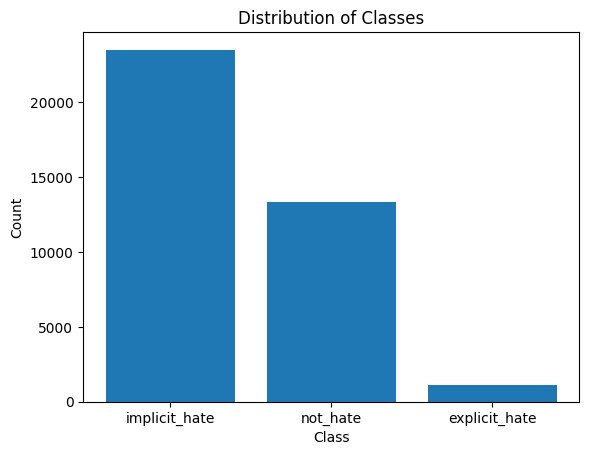

In [ ]:
import matplotlib.pyplot as plt

# Count the number of entries in each class

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(class_counts.index, class_counts.values)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes')
plt.show()

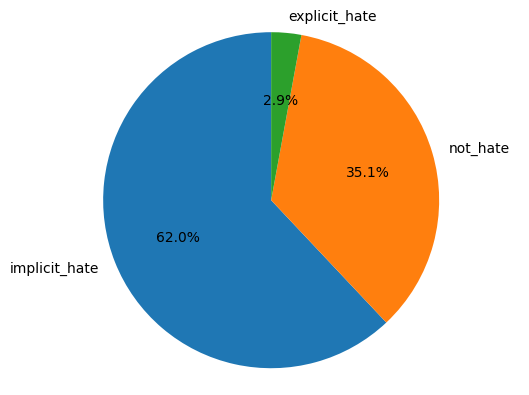

In [ ]:
import matplotlib.pyplot as plt

counts = final_df['class'].value_counts()
labels = counts.index
sizes = counts.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()


In [ ]:
percentages = final_df['class'].value_counts(normalize=True) * 100
print(percentages)

implicit_hate    62.021541
not_hate         35.093184
explicit_hate     2.885275
Name: class, dtype: float64


In [ ]:
final_df = final_drp_df[['post','class']]
final_df['class'].replace(['not_hate', 'explicit_hate', 'implicit_hate'],
                        ['no', 'yes', 'yes'], inplace = True)
final_df

<ipython-input-63-676532b2c3ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['class'].replace(['not_hate', 'explicit_hate', 'implicit_hate'],


,post,class
0,""" : jewish harvard professor noel ignatiev w...",yes
1,b.higher education is a part of european cult...,no
2,"has a problem with "" the whites "" "" and "" "" ...",no
3,is yasir qadhi a hate preacher for calling ch...,no
4,"rt "" : how three million germans mass murder...",no
...,...,...
25690,"Seeing prostitutes is morally wrong, but being...",yes
25691,I wonder how many females I raped today I spen...,yes
25692,Having a criminal record is more attractive to...,yes
25693,Another advantage of being a female: getting b...,yes


In [ ]:
class_counts = final_df['class'].value_counts()
print(class_counts)

no     13294
yes    12401
Name: class, dtype: int64


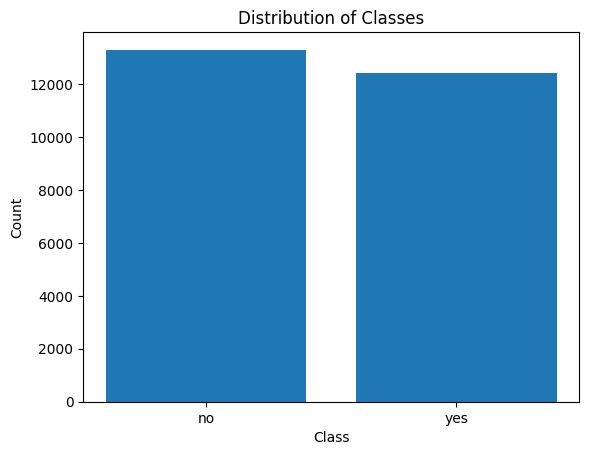

In [ ]:
import matplotlib.pyplot as plt

# Count the number of entries in each class

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(class_counts.index, class_counts.values)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes')
plt.show()

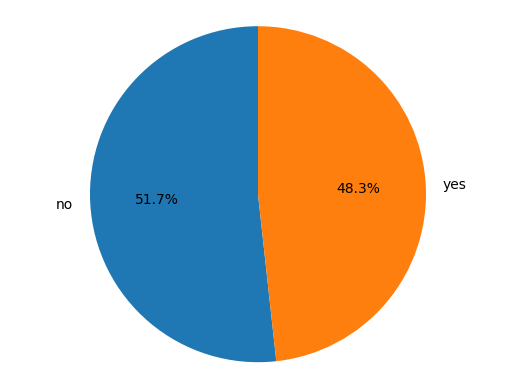

In [ ]:
import matplotlib.pyplot as plt

counts = final_df['class'].value_counts()
labels = counts.index
sizes = counts.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()


## The different types of classes within implicit hate speech

In [ ]:
import numpy as np
#creating a column combined to get the implicit classes
final_classes = final_drp_df
def combine_columns(row):
    if row['class'] == "implicit_hate":
        return str(row['implicit_classes'])
    elif row['class'] == "explicit_hate":
        return 'explicit'
    else:
        return 'no'

final_classes['combined'] = final_drp_df.apply(combine_columns, axis=1)
print(np.unique(final_classes['combined']))

['explicit' 'incitement' 'inferiority' 'irony' 'no' 'other'
 'stereotypical' 'threatening' 'white_grievance']


The different types of classes within implicit hate speech are 'incitement', 'inferiority, 'irony', 'other', 'stereotypical', ' threatening', 'white_grievance'. The other two classes are 'no' (indicating it is not hate speech) and 'explicit' (indicating it is explicit hate speec)

In [ ]:
class_counts = final_classes['combined'].value_counts()
print(class_counts)

no                 13294
white_grievance     2736
incitement          2109
stereotypical       2006
inferiority         1720
threatening         1378
irony               1249
explicit            1093
other                110
Name: combined, dtype: int64


The number of samples are as follows:

no:               13294

white_grievance:     2736

incitement:          2109

stereotypical:       2006

inferiority:         1720

threatening:         1378

irony:               1249

explicit:            1093

other:                110


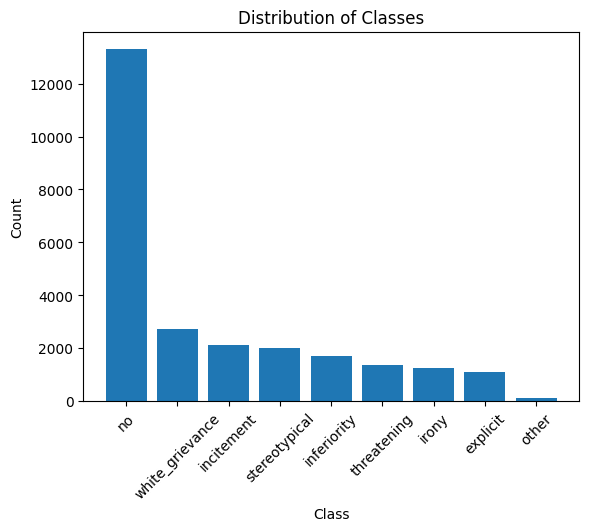

In [ ]:
import matplotlib.pyplot as plt

# Count the number of entries in each class

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(class_counts.index, class_counts.values)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Distribution of Classes')

# Set x-axis tick locations and labels
ax.set_xticks(class_counts.index)
ax.set_xticklabels(class_counts.index, rotation=45)

plt.show()


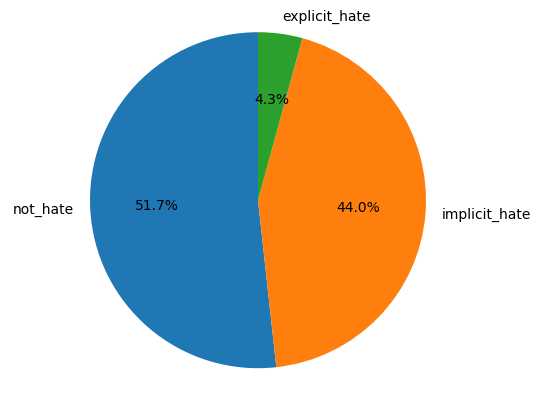

In [ ]:
import matplotlib.pyplot as plt

counts = final_classes['class'].value_counts()
labels = counts.index
sizes = counts.values
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()


# **Running a non Deep Learning Model**
 

It was decided to run **Logistic Regression** for this purpose. Logistic Regression is an algorithm that is popularly used for binary classification tasks because of its ability to handle high-dimensional and noisy data, its robustness to overfitting, and its good performance on a wide range of datasets. 

# Running Logistic Regression

## (a) Running Logistic Regression **without** checking which class of implicit hate speech it is





In this part, we are only classifying whether the text is hate speech or not. The text is considered to be hate speech if it is either explicit or implicit hate speech.

In [ ]:
final_df_without_classes = final_drp_df[['post','class']]
final_df_without_classes['class'].replace(['not_hate', 'explicit_hate', 'implicit_hate'],
                        ['no', 'yes', 'yes'], inplace = True)
final_df_without_classes


<ipython-input-71-980e89944340>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_without_classes['class'].replace(['not_hate', 'explicit_hate', 'implicit_hate'],


,post,class
0,""" : jewish harvard professor noel ignatiev w...",yes
1,b.higher education is a part of european cult...,no
2,"has a problem with "" the whites "" "" and "" "" ...",no
3,is yasir qadhi a hate preacher for calling ch...,no
4,"rt "" : how three million germans mass murder...",no
...,...,...
25690,"Seeing prostitutes is morally wrong, but being...",yes
25691,I wonder how many females I raped today I spen...,yes
25692,Having a criminal record is more attractive to...,yes
25693,Another advantage of being a female: getting b...,yes


### Preprocessing data

Removing the stop words

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    return text

final_df_without_classes['post'] = final_df_without_classes['post'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-72-aaab2655cd6f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_without_classes['post'] = final_df_without_classes['post'].apply(preprocess_text)


Text Preprocessing and Label Encoding

 We are transforming the text data in the 'post' column into a matrix of TF-IDF features

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(final_df_without_classes['post'])

le = LabelEncoder()
y = le.fit_transform(final_df_without_classes['class'])

In [ ]:
X

<25695x23486 sparse matrix of type '<class 'numpy.float64'>'
	with 225093 stored elements in Compressed Sparse Row format>

In [ ]:
y

array([1, 0, 0, ..., 1, 1, 1])

Splitting into test and train data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


print(X_train.shape)
print(y_train.shape)
print(X.shape[0] == y.shape[0])

(17986, 23486)
(17986,)
True


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model object
logr = LogisticRegression()

# Fit the model to the training data
logr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logr.predict(X_test)

# Evaluate the model performance
accuracy = logr.score(X_test, y_test)
print("Accuracy:", accuracy)
# X_explanation_train = X_explanation_train.reset_index(drop=True)
# X_explanation_test = X_explanation_test.reset_index(drop=True)
# y_explanation_train = y_explanation_train.reset_index(drop=True)
# y_explanation_test = y_explanation_test.reset_index(drop=True)

Accuracy: 0.7766247243481644


The accuracy in this case was 77.66%




## **Analysing using F1 score**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
y_pred = logr.predict(X_test)

f1 = f1_score(y_test, y_pred)
print(f"The overall f1 score is {f1}")
# calculate the classification report
report = classification_report(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convert dictionary to DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Convert DataFrame to Markdown table
report_table = report_df.to_markdown()
original_labels = le.classes_

# print the encoded labels and their corresponding original labels
for encoded_label, original_label in enumerate(original_labels):
    print(f'{encoded_label} --> {original_label}')
# Print Markdown table
print(report_table)

The overall f1 score is 0.7637860082304526
0 --> no
1 --> yes
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.774045 | 0.802757 |   0.78814  | 3990        |
| 1            |    0.779614 | 0.748588 |   0.763786 | 3719        |
| accuracy     |    0.776625 | 0.776625 |   0.776625 |    0.776625 |
| macro avg    |    0.776829 | 0.775673 |   0.775963 | 7709        |
| weighted avg |    0.776732 | 0.776625 |   0.776391 | 7709        |


The overall f1 score is 0.764. The f1 score for the class "No" is 0.788 and the f1 score for the class "Yes" is 0.764

The f1 score is relatively high overall and for both class individually. This is because (as seen in the classification report) the support for both classes were high and more or less equal

## Running the Logistic Regression with returning whether it is explicit or implicit hate speech and if it is implicit hate speech, then what class of implicit hate speech it is.

In this part, we are classifying whether the text is hate speech or not. We are also classifying the type of hate speech it is. There are 8 types of hate speech : explicit, incitement, inferiority , irony, no, other, stereotypical, threatening, and white_grievance

Preprocessing the data

In [ ]:
final_df_w_classes = final_drp_df
def combine_columns(row):
    if row['class'] == "implicit_hate":
        return str(row['implicit_classes'])
    elif row['class'] == "explicit_hate":
        return 'explicit'
    else:
        return 'no'

final_df_w_classes['combined'] = final_drp_df.apply(combine_columns, axis=1)
final_df_w_classes = final_df_w_classes[['post','combined']]

Text Preprocessing and Label Encoding

 We are transforming the text data in the 'post' column into a matrix of TF-IDF features

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(final_df_w_classes['post'])

le = LabelEncoder()
y = le.fit_transform(final_df_w_classes['combined'])

In [ ]:
X

<25695x22171 sparse matrix of type '<class 'numpy.float64'>'
	with 353928 stored elements in Compressed Sparse Row format>

In [ ]:
y

array([8, 4, 4, ..., 6, 2, 3])

Splitting into test and train data

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


print(X_train.shape)
print(y_train.shape)
print(X.shape[0] == y.shape[0])

(17986, 22171)
(17986,)
True


In [ ]:
model = LogisticRegression(multi_class='multinomial', solver='sag')
model.fit(X_train, y_train)

# Make predictions on new data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = model.score(X_test, y_test)

In [ ]:
print(accuracy)

0.6335452069010248


The accuracy in this case was 63.35%

## **Analysing using F1 score**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
print(f"The overall f1 score is {f1}")
# calculate the classification report
report = classification_report(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
report_df = pd.DataFrame(report_dict).transpose()
report_table = report_df.to_markdown()

original_labels = le.classes_
for encoded_label, original_label in enumerate(original_labels):
    print(f'{encoded_label} --> {original_label}')

print(report_table)

The overall f1 score is 0.5823355569620349
0 --> explicit
1 --> incitement
2 --> inferiority
3 --> irony
4 --> no
5 --> other
6 --> stereotypical
7 --> threatening
8 --> white_grievance
|              |   precision |    recall |   f1-score |     support |
|:-------------|------------:|----------:|-----------:|------------:|
| 0            |    0.555556 | 0.0793651 |   0.138889 |  315        |
| 1            |    0.67234  | 0.245342  |   0.359499 |  644        |
| 2            |    0.738318 | 0.299242  |   0.425876 |  528        |
| 3            |    0.680412 | 0.173228  |   0.276151 |  381        |
| 4            |    0.630119 | 0.944862  |   0.756041 | 3990        |
| 5            |    1        | 0         |   0        |   25        |
| 6            |    0.578947 | 0.352445  |   0.438155 |  593        |
| 7            |    0.633229 | 0.507538  |   0.563459 |  398        |
| 8            |    0.650549 | 0.354491  |   0.458915 |  835        |
| accuracy     |    0.633545 | 0.633545  |  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The overall f1 score is 0.5822. The f1 score for the classes are defined as follows:

1. explicit -> 0.138889
2. incitement -> 0.359499
3. inferiority -> 0.425876
4. irony -> 0.276151
5. no -> 0.756041
6. other -> 0
7. stereotypical -> 0.438155
8. threatening -> 0.563459
9. white_grievance -> 0.458915







The f1 score is relatively high overall but less than the previous case (when we weren't trying to find the specific classes of implicit hate speech). This could stem from the fact that when we are predicting only two classes the classes are more distinguishable than in the case of predicting 9 classes

The f1 scores for individual classes is directly related to what its support is, i.e if the support is high it has a relatively higher f1 score. Hence, overall, "no" has the highest F1 score of 0.847 (it also has the highest support of 3990). Within the different types of hate speech, the highest F1 score is for "threatening", which is quite interesting since it only has a support of 398 (which is low compared to the other types of hate speech). The type of hate speech with the lowest F1 score is explicit hate speech, which has a relatively low support (but not the lowest!) of 0.167

# Running a baseline DL model

We will use a feedforward neural network for this purpose

## (a) FeedForward Neural network without checking which class of implicit hate speech it is

Preprocessing the data

In [ ]:
final_df_without_classes

,post,class
0,jewish harvard professor noel ignatiev wants...,yes
1,bhigher education part european culture import...,no
2,problem whites christians go ahead fre...,no
3,yasir qadhi hate preacher calling christians ...,no
4,rt three million germans mass murdered destr...,no
...,...,...
25690,seeing prostitutes morally wrong one why women...,yes
25691,i wonder many females i raped today i spent lo...,yes
25692,having criminal record attractive women phd a ...,yes
25693,another advantage female getting looks,yes


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(final_df_without_classes['post']).toarray()
y = final_df_without_classes['class'].apply(lambda x: 1 if x == 'yes' else 0).values

In [ ]:
Counter(y)

Counter({1: 12401, 0: 13294})

Splitting into testing and training data

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ff_model = Sequential()
ff_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
ff_model.add(Dense(32, activation='relu'))
ff_model.add(Dense(1, activation='sigmoid'))

# compile the model
ff_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# train the model on the training data
ff_model.fit(X_train, y_train, epochs=20, batch_size=32)

# evaluate the model on the testing data
loss, accuracy = ff_model.evaluate(X_test, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

Epoch 1/20
643/643 [==============================] - 4s 4ms/step - loss: 0.5724 - accuracy: 0.6996
Epoch 2/20
643/643 [==============================] - 3s 4ms/step - loss: 0.4773 - accuracy: 0.7712
Epoch 3/20
643/643 [==============================] - 2s 3ms/step - loss: 0.4206 - accuracy: 0.8131
Epoch 4/20
643/643 [==============================] - 2s 3ms/step - loss: 0.3420 - accuracy: 0.8605
Epoch 5/20
643/643 [==============================] - 2s 3ms/step - loss: 0.2557 - accuracy: 0.9008
Epoch 6/20
643/643 [==============================] - 2s 3ms/step - loss: 0.1814 - accuracy: 0.9334
Epoch 7/20
643/643 [==============================] - 3s 4ms/step - loss: 0.1263 - accuracy: 0.9545
Epoch 8/20
643/643 [==============================] - 3s 5ms/step - loss: 0.0950 - accuracy: 0.9652
Epoch 9/20
643/643 [==============================] - 2s 3ms/step - loss: 0.0743 - accuracy: 0.9720
Epoch 10/20
643/643 [==============================] - 2s 3ms/step - loss: 0.0628 - accuracy: 0.9760

The accuracy in this case is 80.77%

# Analyzing using F1 score

In [ ]:
from sklearn.metrics import f1_score

# predict the classes for the test data
y_pred = ff_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# calculate the f1 score
f1_score = f1_score(y_test, y_pred)
y_pred = y_pred.ravel()

# get the classification report, which includes the precision, recall, F1 score and support for each class
report = classification_report(y_test, y_pred)



print(f"Overall f1 score: {f1_score}")

print(report)

161/161 [==============================] - 1s 6ms/step
Overall f1 score: 0.8103646833013437
              precision    recall  f1-score   support

           0       0.86      0.76      0.81      2696
           1       0.76      0.86      0.81      2443

    accuracy                           0.81      5139
   macro avg       0.81      0.81      0.81      5139
weighted avg       0.81      0.81      0.81      5139



The overall f1 score is 0.813. 

The f1 score for the classes are defined as follows:

No -> 0.82

Yes -> 0.81

The f1 score is relatively high overall and for both class individually. This is because (as seen in the classification report) the support for both classes were high and more or less equal

# (b) Running FeedForward Neural network on data which will also classify the type of implicit hate speech it is

Preprocessing the data

In [ ]:
final_df_w_classes

,post,combined
0,""" : jewish harvard professor noel ignatiev w...",white_grievance
1,b.higher education is a part of european cult...,no
2,"has a problem with "" the whites "" "" and "" "" ...",no
3,is yasir qadhi a hate preacher for calling ch...,no
4,"rt "" : how three million germans mass murder...",no
...,...,...
25690,"Seeing prostitutes is morally wrong, but being...",irony
25691,I wonder how many females I raped today I spen...,irony
25692,Having a criminal record is more attractive to...,stereotypical
25693,Another advantage of being a female: getting b...,inferiority


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create a TF-IDF vectorizer and fit it on the text
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(final_df_w_classes['post']).toarray()

# Pad the sequences to the same length
max_length = X.shape[1]
padded_sequences = pad_sequences(X, maxlen=max_length, padding='post')

# Create the label encoder and encode the classes
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(final_df_w_classes['combined'])


Splitting into test and train data

In [ ]:
import tensorflow as tf
# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_length)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(accuracy))

Epoch 1/20
643/643 [==============================] - 3s 3ms/step - loss: 1.7098 - accuracy: 0.5150 - val_loss: 1.6076 - val_accuracy: 0.5246
Epoch 2/20
643/643 [==============================] - 2s 3ms/step - loss: 1.6322 - accuracy: 0.5156 - val_loss: 1.6060 - val_accuracy: 0.5246
Epoch 3/20
643/643 [==============================] - 3s 4ms/step - loss: 1.6316 - accuracy: 0.5156 - val_loss: 1.6070 - val_accuracy: 0.5246
Epoch 4/20
643/643 [==============================] - 5s 8ms/step - loss: 1.6308 - accuracy: 0.5156 - val_loss: 1.6048 - val_accuracy: 0.5246
Epoch 5/20
643/643 [==============================] - 3s 5ms/step - loss: 1.6301 - accuracy: 0.5156 - val_loss: 1.6024 - val_accuracy: 0.5246
Epoch 6/20
643/643 [==============================] - 2s 3ms/step - loss: 1.6297 - accuracy: 0.5158 - val_loss: 1.6031 - val_accuracy: 0.5246
Epoch 7/20
643/643 [==============================] - 2s 3ms/step - loss: 1.6289 - accuracy: 0.5159 - val_loss: 1.6034 - val_accuracy: 0.5246
Epoch 

The Accuracy in this case is 52.5%

## Analysing using F1 score

In [ ]:
from sklearn.metrics import classification_report

# Predict the class labels of the test set
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Convert the encoded labels back to their original form
y_test_orig = label_encoder.inverse_transform(y_test)
y_pred_orig = label_encoder.inverse_transform(y_pred)

# Print the classification report
print(y_pred_prob)
print(classification_report(y_test_orig, y_pred_orig, zero_division=1))


161/161 [==============================] - 0s 2ms/step
[[0.04119035 0.07880219 0.06782217 ... 0.0814682  0.05627615 0.105716  ]
 [0.04119035 0.07880219 0.06782217 ... 0.0814682  0.05627615 0.105716  ]
 [0.04119035 0.07880219 0.06782217 ... 0.0814682  0.05627615 0.105716  ]
 ...
 [0.04119035 0.07880219 0.06782217 ... 0.0814682  0.05627615 0.105716  ]
 [0.04119035 0.07880219 0.06782217 ... 0.0814682  0.05627615 0.105716  ]
 [0.04119035 0.07880219 0.06782217 ... 0.0814682  0.05627615 0.105716  ]]
                 precision    recall  f1-score   support

       explicit       1.00      0.00      0.00       195
     incitement       1.00      0.00      0.00       417
    inferiority       0.00      0.00      0.00       352
          irony       1.00      0.00      0.00       258
             no       0.52      1.00      0.69      2696
          other       1.00      0.00      0.00        12
  stereotypical       1.00      0.00      0.00       407
    threatening       1.00      0.00      0.

The overall f1 score is 0.36. 

The f1 score for the classes are defined as follows:

explicit -> 0

incitement -> 0

inferiority -> 0

irony -> 0

no -> 0.69

other -> 0

stereotypical -> 0

threatening -> 0.01

white_grievance -> 0


The reason why the F1 scores and accuracy is so low for the purpose of classifying the text into 9 different classes could be the fact that feedforward neural networks are shallow networks. This means that they have a limited number of layers and may not have enough capacity to handle the increased complexity of a multi-class classification problem.

# Large Language Models

Large language models (LLMs) are Deep Learning models that are trained on large amounts of text data to generate human-like language. These models are known for their capabilities of performing a wide variety of natural language processing (NLP) tasks, such as text summarization, language translation, and sentiment analysis.

We will fine-tune two LLMs, namely **GPT-3** and **Alpaca**, and compare their results. Specifically, we will compare the performance of GPT-3 before and after fine-tuning, as well as that of Alpaca before and after fine-tuning. Furthermore, we will also compare the performance of the two fine-tuned LLMs against each other.

We are performing two rounds of fine-tuning on the two Language Model models. The first round aims to detect if a text is hate speech or not. The target variable in this round is binary, either **'yes'** or **'no'**. The second round aims to identify the specific type of hate speech in the text, with the target variable having multiple categories: **'incitement', 'inferiority', 'irony', 'other', 'stereotypical', 'threatening', 'white_grievance'**, and **'no'**.

## Creating the CSV files to fine tune the LLMs

In [ ]:
set(final_drp_df['implicit_classes'])
final_df_implicit_classes = final_drp_df

def combine_columns(row):
    if row['class'] == "implicit_hate":
        return str(row['implicit_classes'])
    elif row['class'] == "explicit_hate":
        return 'explicit'
    else:
        return 'no'

final_df_implicit_classes['combined'] = final_drp_df.apply(combine_columns, axis=1)
final_df_implicit_classes
final_df_implicit_classes = final_df_implicit_classes[['post','combined']]
final_df_implicit_classes = final_df_implicit_classes.rename(columns={'combined': 'class' ,'post':'input'})
final_df_implicit_classes['instruction'] = 'Answer whether this is hate speech or not and if it is hate speech, provide the type of hate speech it is'
final_df_implicit_classes.to_csv('final_for_implicit_class.csv')


In [ ]:
final_drp_df['class'].replace(['not_hate', 'explicit_hate', 'implicit_hate'],
                        ['no', 'yes', 'yes'], inplace=True)

In [ ]:
final_df_no_classes = final_drp_df[['post','class']]
Counter(final_df_no_classes['class'])
final_df_no_classes.to_csv('final_no_class.csv')